In [1]:
#This notebook inspects data for the autoencoder based analysis of the patchseq dataset.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
import feather
import numpy as np
import pandas as pd
import scipy.io as sio
from data_funcs import reorder_ps_TE,extract_arrays,TEM_dataset, TEM_rem_lowsampled_classes

#Parameters
#beta_threshold controls number of genes that remain in the final list (Jeremy: use 0.2-0.4) 
#BetaScore is a measure of differential expression for each gene.
beta_threshold = 0.4

#T files: /allen/programs/celltypes/workgroups/rnaseqanalysis/shiny/patch_seq/star/mouse_patchseq_VISp_20191113_collapsed40_cpm/
#E files: /allen/programs/celltypes/workgroups/ivscc/nathang/spca_output/sparse_pca_components_mMET_curated_Nov11.csv
#M files: /allen/programs/celltypes/workgroups/ivscc/nathang/morph_features/mouse_met_Nov11_ccf_soma_locations.csv
#E features: features_met_mouse_Feb62020.csv - From Agata
pth={}

base_path = '/Users/fruity/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/'
pth['ref_colors']       = base_path + 'type_color_reference.csv' #Generated for inhibitory types from the FACS annotations
pth['ps_T_dat']         = base_path + 'mouse_patchseq_VISp_20191113_collapsed40_cpm_data.feather'
pth['ps_T_ann']         = base_path + 'mouse_patchseq_VISp_20191113_collapsed40_cpm_anno.feather'
pth['ps_E_dat']         = base_path + 'sparse_pca_components_mMET_curated_Nov11.csv'
pth['ps_M_dat']         = base_path + 'mouse_met_Nov11_ccf_soma_locations.csv'
pth['jeremy_gene_set']  = base_path + 'good_genes_beta_score.csv'
pth['QC_cells']         = base_path + 'specimen_ids_for_paper_Nov_2019.txt'
pth['save']             = base_path

In [4]:
#Load reference colors
ref = pd.read_csv(pth['ref_colors'])

In [5]:
#Load patchseq T data and annotations
orig_dat = feather.read_dataframe(pth['ps_T_dat'])
orig_ann = feather.read_dataframe(pth['ps_T_ann'])

In [6]:
keep_cell_id = pd.read_csv(pth['QC_cells'],header=None,names=['spec_id'])
keep_gene_id = pd.read_csv(pth['jeremy_gene_set'])
keep_gene_id = keep_gene_id[keep_gene_id.BetaScore>beta_threshold]['Gene'].to_list()

In [7]:
#Restrict T data based on genes:
keepcols = ['sample_id'] + keep_gene_id
orig_dat = orig_dat[keepcols]

In [8]:
#Restrict cells to good quality cells if a cell list provided:
if keep_cell_id is not None:
    #Core + I1 + I2 + I3 cells:
    cond1 = orig_ann['Tree_call_label'].isin(['Core','I1','I2','I3'])
    cond2 = orig_ann['spec_id_label'].isin(keep_cell_id['spec_id'].values.astype(str))
    ps_T_ann = orig_ann[cond1 & cond2].reset_index(drop=True)
    ps_T_dat = orig_dat[cond1 & cond2].reset_index(drop=True)
    assert np.array_equal(ps_T_dat['sample_id'].values,ps_T_ann['sample_id'].values),'T data and annotations are mismatched'

In [9]:
ps_T_dat.shape

(3411, 1253)

In [10]:
#cluster_labels are now called topLeaf_label. Colors are determined from the facs reference:
ps_T_ann['cluster_label'] = ps_T_ann['topLeaf_label'].values
ps_T_ann['cluster_id'] = ps_T_ann['topLeaf_id'].values
ps_T_ann['map_conf'] = ps_T_ann['Tree_call_label'].values

#Delete the color annotations in the patchseq file, and replace with FACS reference colors
del ps_T_ann['cluster_color']
ps_T_ann = ps_T_ann.join(ref.set_index('celltype'),on='cluster_label') 

In [11]:
#Load E data
orig_E_dat = pd.read_csv(pth['ps_E_dat'])
orig_E_dat.rename(columns = {orig_E_dat.columns[0]: 'spec_id_label'}, inplace=True)
cond1 = orig_E_dat['spec_id_label'].isin(keep_cell_id['spec_id'].values.astype(str))
ps_E_dat = orig_E_dat[cond1]

In [12]:
ps_Tcat_dat, ps_Tcat_ann, ps_Ecat_dat, ispairedT, ispairedE = reorder_ps_TE(ps_T_dat,ps_T_ann,ps_E_dat)
matdict = extract_arrays(ps_Tcat_dat, ps_Tcat_ann, ispairedT, ps_Ecat_dat, ispairedE, keep_gene_id)

-----------------------------------------------
0 exclusive, 3411 matched, total 3411 in T
-----------------------------------------------
297 exclusive, 3411 matched, total 3708 in E


In [13]:
#Core and I1 map confidently to a single leaf node
#I2 and I3 have good quality transcriptomic data, but unreliable mapping results
pd.Series(matdict['map_conf']).value_counts().to_frame(name='counts')

,counts
Core,1965
I1,780
I2,602
I3,64


**Counts of sampled transcriptomic types**

In [14]:
X = ps_Tcat_ann['cluster_label'].value_counts().to_frame()
X.rename(columns={'cluster_label': 'counts'},inplace=True)
Y = ps_Tcat_ann[['cluster_id','cluster_label','cluster_color']].drop_duplicates().sort_values(by='cluster_label').reset_index(drop=True)
X = Y.set_index('cluster_label').join(X).reset_index()

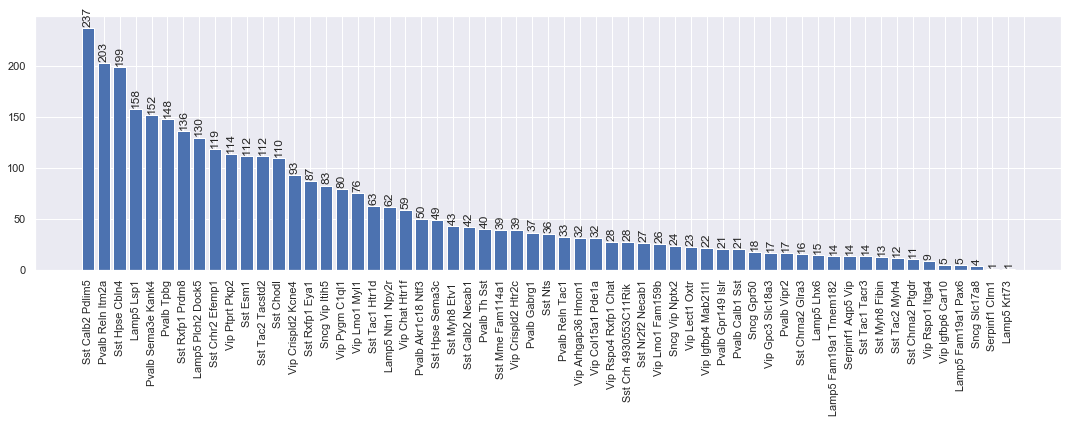

In [15]:
X = X.sort_values(by='counts',ascending=False).reset_index()
fig = plt.figure(figsize = (15,6))
for i in np.arange(X['counts'].values.size):
    plt.bar(x=i,height=X['counts'].values[i],color='b')
    plt.text(i,X['counts'].values[i]+3,str(X['counts'].values[i]),rotation = 90,horizontalalignment='center')
ax = plt.gca()           
ax.set_xticks(np.arange(0,60,1))
ax.set_xticklabels(X['cluster_label'].values, rotation=90)
plt.tight_layout()
plt.show()

In [16]:
from analysis_tree_helpers import HTree
htree_filename = '/Users/fruity/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/dend_RData_Tree_20181220.csv'
htree = HTree(htree_file=htree_filename)
htree_df = htree.obj2df()

X = X.merge(right=htree_df,how='left',left_on='cluster_label',right_on='child')
X = X[['cluster_label','cluster_color','counts','x']]
X = X.sort_values(by='x')
X.reset_index(drop=True,inplace=True)

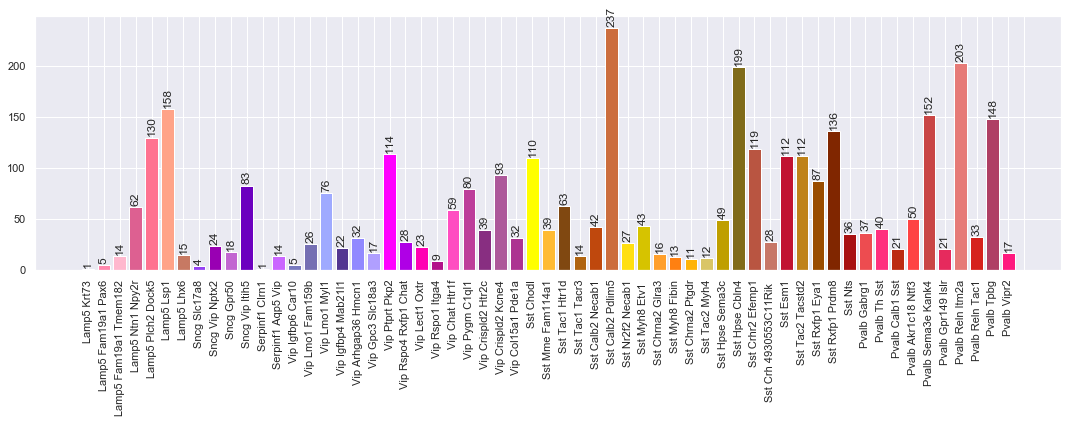

In [17]:
fig = plt.figure(figsize = (15,6))
for i in np.arange(X['counts'].values.size):
    plt.bar(x=i,height=X['counts'].values[i],color=X['cluster_color'].values[i])
    plt.text(i,X['counts'].values[i]+3,str(X['counts'].values[i]),rotation = 90,horizontalalignment='center')
ax = plt.gca()           
ax.set_xticks(np.arange(0,60,1))
ax.set_xticklabels(X['cluster_label'].values, rotation=90)
plt.tight_layout()
plt.show()

**Electrophysiology feature-wise distributions**

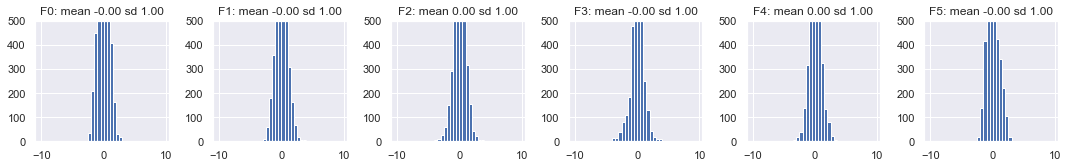

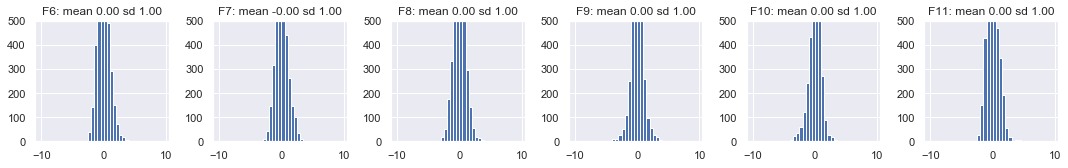

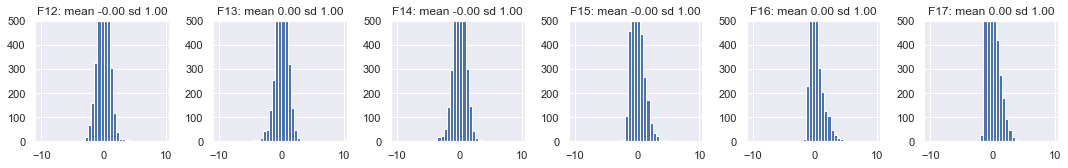

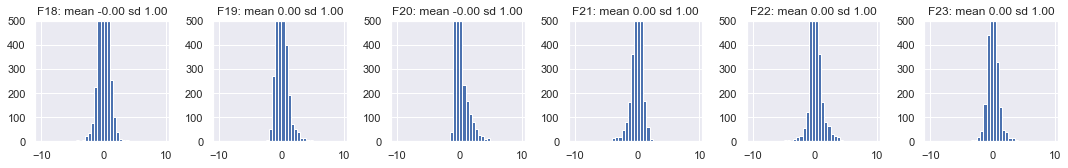

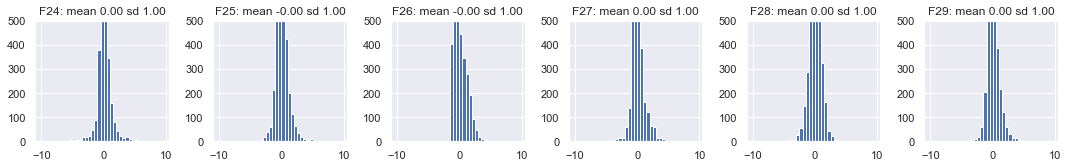

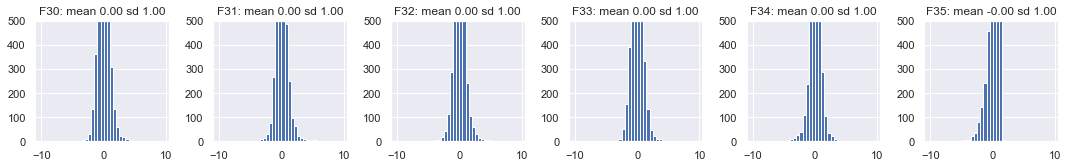

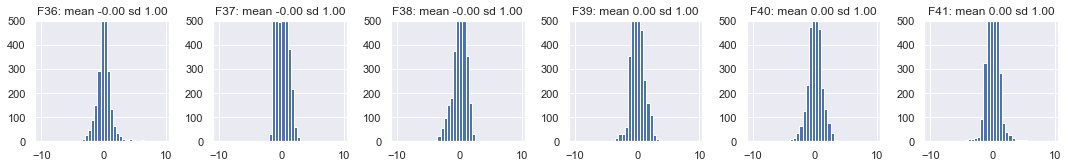

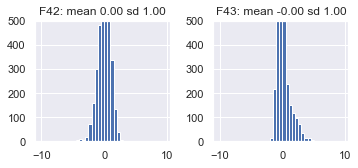

In [18]:
matdict['E_dat'].shape
nplots_perline = 6
for i in range(matdict['E_dat'].shape[1]):
    if i%nplots_perline==0:
        plt.figure(figsize = (15,2.5))
    plt.subplot(1,nplots_perline,i%nplots_perline+1)
    ax = plt.gca()
    ax.set_title('F{:d}: mean {:.2f} sd {:.2f}'.format(i,np.mean(matdict['E_dat'][:,i]),np.std(matdict['E_dat'][:,i])))
    ax.set_ylim(0,500)
    counts=plt.hist(matdict['E_dat'][:,i],np.arange(-10,10,0.5))
    bins = counts[1]
    bins = (bins[0:-1]+bins[1:])/2
    counts = counts[0]

    #for j in range(bins.size):
    #    plt.text(bins[j],counts[j],str(counts[j]),rotation = 90,horizontalalignment='center')
    plt.tight_layout()

**Inspect and remove sPC outliers**

In [19]:
all_outliers = np.zeros((matdict['E_dat'].shape[0],), dtype=bool)
for i in range(matdict['E_dat'].shape[1]):
    outlier_ind = np.abs(matdict['E_dat'][:,i] - np.mean(matdict['E_dat'][:,i]))>6*np.std(matdict['E_dat'][:,i])
    outliers = np.sum(outlier_ind)
    if outliers>0:
        print('{:3d} outliers in feature {:d}'.format(outliers,i))
    all_outliers = np.logical_or(all_outliers,outlier_ind)

print('\n')
outlier_inds = np.flatnonzero(all_outliers)
paired_outlier_inds = outlier_inds[matdict['E_ispaired'][outlier_inds]==1]
print(pd.Series(np.sort(matdict['cluster'][paired_outlier_inds])).value_counts())

  1 outliers in feature 10
  2 outliers in feature 12
  1 outliers in feature 16
  8 outliers in feature 18
  3 outliers in feature 19
  3 outliers in feature 20
  4 outliers in feature 21
  6 outliers in feature 22
  2 outliers in feature 23
  9 outliers in feature 24
  1 outliers in feature 25
  1 outliers in feature 26
  3 outliers in feature 27
  4 outliers in feature 29
  4 outliers in feature 31
  3 outliers in feature 34
  2 outliers in feature 35
 15 outliers in feature 36
  1 outliers in feature 41


Vip Crispld2 Kcne4    4
Lamp5 Plch2 Dock5     4
Pvalb Gabrg1          3
Vip Ptprt Pkp2        3
Vip Arhgap36 Hmcn1    3
Pvalb Sema3e Kank4    3
Sst Chrna2 Glra3      3
Sst Hpse Cbln4        3
Pvalb Tpbg            2
Sst Chodl             2
Vip Crispld2 Htr2c    2
Vip Lmo1 Myl1         2
Sst Chrna2 Ptgdr      2
Pvalb Reln Itm2a      2
Vip Rspo1 Itga4       1
Sst Calb2 Pdlim5      1
Sst Crhr2 Efemp1      1
Pvalb Gpr149 Islr     1
Pvalb Th Sst          1
Lamp5 Ntn1 Npy2r      1
Sst M

**Removing sPC feature outliers**

Outliers are detected on a per feature basis. sPCs are z-scored already.

In [20]:
#Set values beyond the 6 sigma in either direction to the boundary.
for i in range(matdict['E_dat'].shape[1]):
    condition = 6*np.std(matdict['E_dat'][:,i])
    outlier_max_ind = (matdict['E_dat'][:,i] - np.mean(matdict['E_dat'][:,i])) > condition
    outlier_min_ind = (matdict['E_dat'][:,i] - np.mean(matdict['E_dat'][:,i])) < -1.0*condition
    
    matdict['E_dat'][outlier_max_ind,i]=condition
    matdict['E_dat'][outlier_max_ind,i]=-1.0*condition

**Get sPC column names**

In [21]:
#Borrowing code from Nathan's notebook to rename ephys columns
import json
with open(base_path+"/spca_components_used_mMET_curated_Nov11.json") as f:
    new_comp_info = json.load(f)
new_col_lookup = {}
counter = 0
for ci in new_comp_info:
    new_col_lookup[ci["key"]] = [str(counter + i) for i, v in enumerate(ci["indices"])]
    counter += len(ci["indices"])

keys_=[]
columns_=[]
for key,value in new_col_lookup.items():
    for i,v in enumerate(value):
        keys_.append(key+'_'+str(i))
        columns_.append(v)
keys_ = np.array(keys_)
columns_ = np.array([int(c) for c in columns_])

sort_ind = np.argsort(columns_)
keys_ = keys_[sort_ind]
columns_ = columns_[sort_ind]

In [22]:
# import pprint
# pprint.pprint(list(zip(columns_,keys_)))

In [23]:
keys_ = [k.strip() for k in keys_]
matdict['spc_name']=np.array(keys_,dtype=object)

In [24]:
for k in matdict.keys(): 
    if '__' not in k:
        print('{:17s}: shape {}'.format(k,matdict[k].shape))

T_dat            : shape (3411, 1252)
T_spec_id_label  : shape (3411,)
T_ispaired       : shape (3411,)
gene_id          : shape (1252,)
cluster          : shape (3411,)
clusterID        : shape (3411,)
cluster_color    : shape (3411,)
sample_id        : shape (3411,)
map_conf         : shape (3411,)
E_dat            : shape (3708, 44)
E_spec_id_label  : shape (3708,)
E_ispaired       : shape (3708,)
spc_name         : shape (44,)


In [25]:
sio.savemat(pth['save']+'PS_v5_beta_0-4_all.mat',matdict)

**IPFX features for the patchseq dataset**

 - Contains many nans
 - Select features that aren't nan across much of the patchseq dataset
 - Standardize features after excluding outliers
 - Save transformation values
 - Use for comparison with the Tolias L4 paper features.
 - Train network with these features

In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import scipy.io as sio
sns.set()

base_path = '/Users/fruity/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/'
matdict = sio.loadmat(base_path+'PS_v5_beta_0-4_all.mat',squeeze_me=True)
E_df = pd.read_csv(base_path+'features_met_mouse_Feb62020.csv')
E_feature_names = E_df.columns[2:]

In [2]:
mat_df = pd.DataFrame({'T_spec_id_label':matdict['T_spec_id_label'],
                       'cluster':matdict['cluster']})

#Keep E data only for cells with T measurements
E_df = mat_df.merge(E_df,how='left',left_on='T_spec_id_label',right_on='specimen_id')

 - Restrict features and samples

In [3]:
#Remove features with more nans than 10% of cells in T data
max_nans_per_feature = round(E_df.shape[0]*0.1) 
keep_features = []
for feature in E_feature_names:
    if E_df[feature].isna().sum()<max_nans_per_feature:
        keep_features.append(feature)

print('{} features kept with < {} nans'.format(len(keep_features),max_nans_per_feature))

#Remove ramp feature (not consistently measured for patch-seq cells re. Agata)
keep_features = [k for k in keep_features if 'ramp' not in k ]
keep_features = [f for f in keep_features if 'mean' not in f]
keep_features = [f for f in keep_features if 'fi_' not in f]
print('{:d} features kept'.format(len(keep_features)))

E_df = E_df[['T_spec_id_label','cluster']+keep_features]

40 features kept with < 341 nans
24 features kept


 - Analyze number of nans per cell type

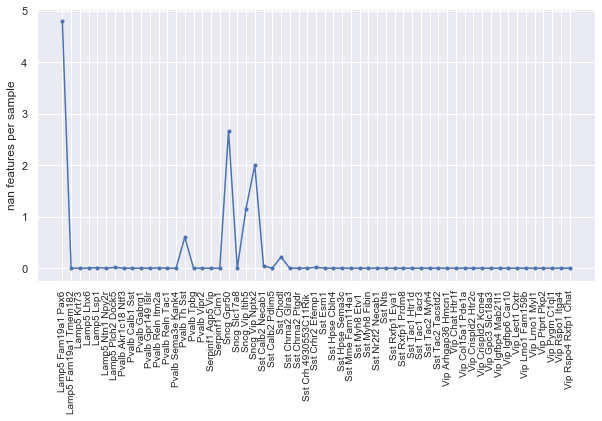

In [4]:
#Number of nans across all kept features per type
A1 = E_df.copy()
A1['nan_count']=A1.isna().sum(axis=1)
A1 = A1.groupby('cluster')['nan_count'].sum()
A1 = pd.DataFrame({'cluster':A1.index, 'nan_counts':(A1.values)})

#Number of cells per type
A2 = E_df.copy()
A2 = A2['cluster'].value_counts()
A2 = pd.DataFrame({'cluster':A2.index, 'samples':A2.values})

#Merge dataframes to inspect nans grouped by types
A = A1.merge(right=A2,left_on = 'cluster',right_on='cluster')
A['nan_ratio'] = A['nan_counts']/A['samples']

plt.figure(figsize=(10,5))
plt.plot(A['cluster'], A['nan_ratio'],'.-')
ax = plt.gca()
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
    tick.set_size(10)
ax.set_ylabel('nan features per sample')
plt.show()

In [5]:
A[A['nan_ratio']>0]

,cluster,nan_counts,samples,nan_ratio
0,Lamp5 Fam19a1 Pax6,24,5,4.800000
4,Lamp5 Lsp1,2,158,0.012658
6,Lamp5 Plch2 Dock5,2,130,0.015385
11,Pvalb Reln Itm2a,1,203,0.004926
14,Pvalb Th Sst,24,40,0.600000
19,Sncg Gpr50,48,18,2.666667
21,Sncg Vip Itih5,96,83,1.156627
22,Sncg Vip Nptx2,48,24,2.000000
23,Sst Calb2 Necab1,2,42,0.047619
25,Sst Chodl,24,110,0.218182


 - Standardize features

1 outliers in ap_1_threshold_v_short_square
1 outliers in ap_1_upstroke_short_square
2 outliers in ap_1_downstroke_short_square
3 outliers in ap_1_upstroke_downstroke_ratio_short_square


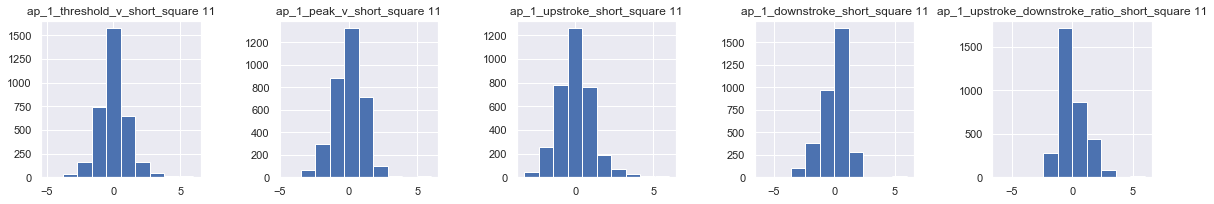

22 outliers in ap_1_width_short_square
3 outliers in ap_1_fast_trough_v_short_square
2 outliers in short_square_current
3 outliers in input_resistance
5 outliers in tau


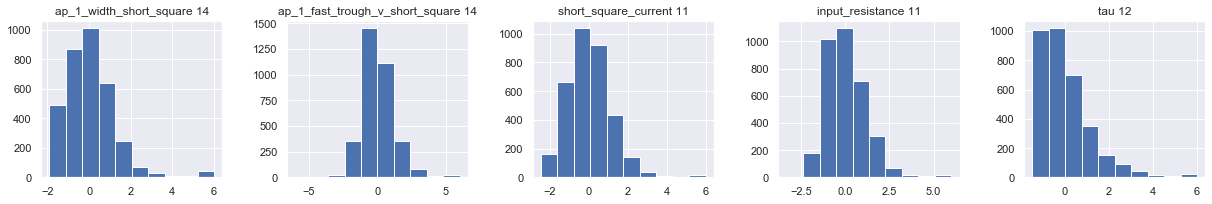

10 outliers in sag_nearest_minus_100
1 outliers in ap_1_threshold_v_0_long_square


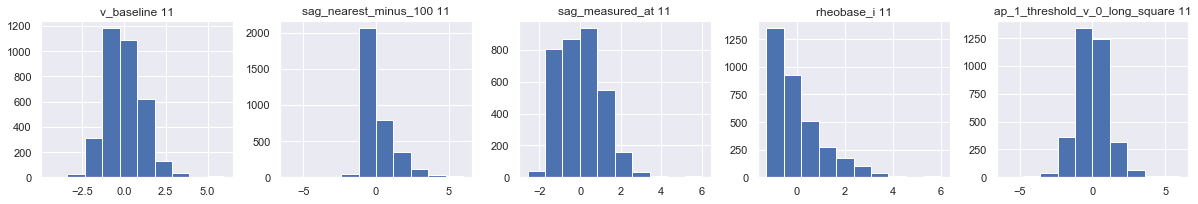

3 outliers in ap_1_upstroke_downstroke_ratio_0_long_square
3 outliers in ap_1_width_0_long_square


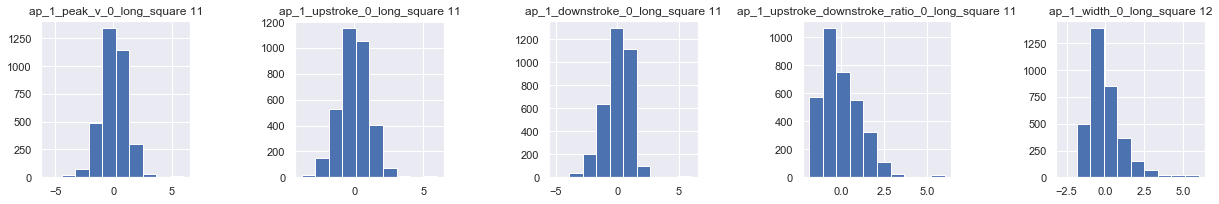

1 outliers in ap_1_fast_trough_v_0_long_square
53 outliers in avg_rate_0_long_square
20 outliers in latency_0_long_square


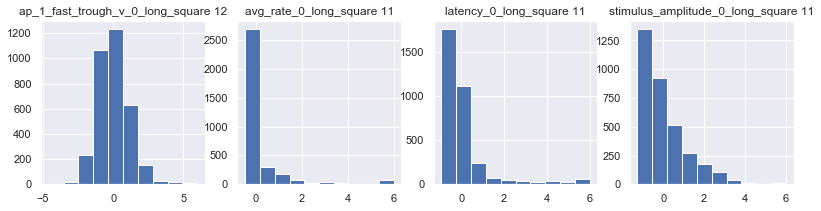

In [6]:
ncols = 5
i = 0
z_absmax = 6.0
n_outliers = 0
feature_mean = []
feature_std = []
for feature in keep_features:
    if i % ncols==0:
        plt.figure(figsize = (17,3))

    e = E_df[feature].copy()
    #Use middle percentile (ignores nans) to calculate means and std
    low = e.dropna().quantile(q=0.01)
    high = e.dropna().quantile(q=0.99)
    

    values = e[e.between(low,high)]
    e_mean = np.mean(values)
    e_std = np.std(values)
    e = (e-e_mean)/e_std
    feature_mean.append(e_mean)
    feature_std.append(e_std)
    
    #Set outliers to boundary
    num_set = (e.gt(z_absmax) | e.lt(-z_absmax)).sum()
    nanind = e.isna()
    e.fillna(10000,inplace=True) #avoiding issues with nans
    e[e > z_absmax]=z_absmax
    e[e < -z_absmax]=-z_absmax
    if num_set>0:
        print('{} outliers in {}'.format(num_set,feature))
    
    plt.subplot(1,ncols,i%ncols+1)
    plt.hist(e)
    e[nanind]=np.nan
    E_df[feature] = e
    
    ax = plt.gca()
    plt.title(feature+' '+str(e.isna().sum()))
    i = i+1
    if i % ncols==0:
        #On completing each row
        plt.tight_layout()
        plt.show()

In [7]:
#Write the ipfx features to dictionary
matdict['E_feature'] = E_df[keep_features].values
matdict['feature_name'] = np.array(keep_features,dtype=object)
matdict['feature_mean'] = np.array(feature_mean,dtype=float)
matdict['feature_std'] = np.array(feature_std,dtype=float)

In [8]:
#Remove samples with spc features that have no T data:
for k in matdict.keys(): 
    if '__' not in k:
        print('{:17s}: shape {}'.format(k,matdict[k].shape))

T_dat            : shape (3411, 1252)
T_spec_id_label  : shape (3411,)
T_ispaired       : shape (3411,)
gene_id          : shape (1252,)
cluster          : shape (3411,)
clusterID        : shape (3411,)
cluster_color    : shape (3411,)
sample_id        : shape (3411,)
map_conf         : shape (3411,)
E_dat            : shape (3708, 44)
E_spec_id_label  : shape (3708,)
E_ispaired       : shape (3708,)
spc_name         : shape (44,)
E_feature        : shape (3411, 24)
feature_name     : shape (24,)
feature_mean     : shape (24,)
feature_std      : shape (24,)


In [9]:
ind = np.isin(matdict['E_spec_id_label'],matdict['T_spec_id_label'])
matdict['E_dat'] = matdict['E_dat'][ind]
matdict['E_spec_id_label'] = matdict['E_spec_id_label'][ind]
matdict['E_ispaired'] = matdict['E_ispaired'][ind]
assert np.array_equal(matdict['E_spec_id_label'],matdict['T_spec_id_label']), 'Order is incorrect'

In [10]:
for k in matdict.keys(): 
    if '__' not in k:
        print('{:17s}: shape {}'.format(k,matdict[k].shape))

T_dat            : shape (3411, 1252)
T_spec_id_label  : shape (3411,)
T_ispaired       : shape (3411,)
gene_id          : shape (1252,)
cluster          : shape (3411,)
clusterID        : shape (3411,)
cluster_color    : shape (3411,)
sample_id        : shape (3411,)
map_conf         : shape (3411,)
E_dat            : shape (3411, 44)
E_spec_id_label  : shape (3411,)
E_ispaired       : shape (3411,)
spc_name         : shape (44,)
E_feature        : shape (3411, 24)
feature_name     : shape (24,)
feature_mean     : shape (24,)
feature_std      : shape (24,)


In [11]:
sio.savemat(base_path+'PS_v5_beta_0-4_pc_ipxf_eqTE.mat',matdict,do_compression=True)

**Un-normalized sPC coefficients and vectors**

In [1]:
import joblib
import pandas as pd
import scipy.io as sio
%matplotlib inline

In [2]:
L = joblib.load('/Users/fruity/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/spca_loadings_mMET_curated_Nov11.pkl')
S = pd.read_csv('/Users/fruity/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/sparse_pca_components_mMET_curated_Nov11_withheaders.csv')
D = sio.loadmat('/Users/fruity/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/PS_v5_beta_0-4_pc_ipxf_eqTE.mat',squeeze_me=True)

In [3]:
L.keys()

dict_keys(['first_ap_v', 'first_ap_dv', 'isi_shape', 'step_subthresh', 'subthresh_norm', 'inst_freq', 'spiking_upstroke_downstroke_ratio', 'spiking_peak_v', 'spiking_fast_trough_v', 'spiking_threshold_v', 'spiking_width', 'inst_freq_norm'])

In [4]:
#These are the original pc coefficients
print('transformed values: ',L['first_ap_v']['transformed_values'].shape)

#These are the original pc vectors
print('loadings: ',L['first_ap_v']['loadings'].shape)

transformed values:  (3708, 7)
loadings:  (300, 7)


In [5]:
from sklearn.linear_model import LinearRegression
import seaborn as sns
sns.set()

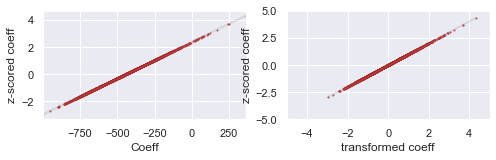

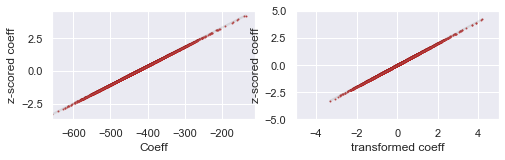

In [6]:
#Checks to ensure that z-scored loadings used previously are linearly related to original loadings:
for i in range(2):
    x = L['first_ap_v']['transformed_values'][:,i] #original 
    y = S['first_ap_v_'+str(i)].values             #z-scored 

    #Estimate the mean and std used for z-scoring
    regressor = LinearRegression()
    regressor.fit(y[...,np.newaxis],x[...,np.newaxis])
    stdval = regressor.coef_
    meanval = regressor.intercept_

    plt.figure(figsize = (8,2))
    plt.subplot(1,2,1)
    sns.regplot(x, y, scatter_kws={'s':1,'color':'firebrick'},line_kws={'color':'k','alpha':0.1})
    ax = plt.gca()
    ax.set_xlabel('Coeff')
    ax.set_ylabel('z-scored coeff')

    #Check by normalizing the original data:
    plt.subplot(1,2,2)
    sns.regplot((x-meanval)/stdval,y,scatter_kws={'s':1,'color':'firebrick'},line_kws={'color':'k','alpha':0.1})
    ax = plt.gca()
    ax.set_xlabel('transformed coeff')
    ax.set_ylabel('z-scored coeff')
    ax.set_ylim(-5,5)
    ax.set_xlim(-5,5)
    plt.show()

In [7]:
def pc2timeseries(L):
    '''
    Args:
    L: pc summary file with pc and loadings from Nathan.
    
    Returns:
    T: list with [cells x time] reconstructed time series from the pcs for each sub-expt
    C: list with [cells x loadings] that are not normalized for each sub-expt
    '''
    #Components used by the autoencoder
    pc_summary= {'first_ap_v': 5,
             'first_ap_dv':6,
             'isi_shape':3,
             'step_subthresh':2,
             'subthresh_norm':4,
             'inst_freq':6,
             'spiking_upstroke_downstroke_ratio':2,
             'spiking_peak_v':2,
             'spiking_fast_trough_v':2,
             'spiking_threshold_v':3,
             'spiking_width':2,
             'inst_freq_norm':7}
    
    T = []
    C = []
    for key in pc_summary:
        
        inds = np.arange(pc_summary[key])
        A = L[key]['transformed_values'][:,inds]
        B = L[key]['loadings'][:,inds].transpose()
        T.append(A@B)
        C.append(L[key]['transformed_values'][:,inds])
        
    def centre_scale(X,center=False):
        #Remove mean
        if center:
            X = (X-np.mean(X,axis=0))
        
        #Total variance for this sub-experiment = number of PC retained
        scale_factor = (X.shape[1]**0.5)/(np.sum(np.var(X,axis=0))**0.5)
        Xscaled = X*scale_factor
        
        return Xscaled
    
    #Center and scale each component:
    Csc = C.copy()
    for i in range(len(C)):
        Csc[i] = centre_scale(X = C[i])
        
    
    #Plot the variances of the centered_scaled loadings
    plt.figure(figsize=(15,4))
    ind = np.cumsum([value for _,value in pc_summary.items()])
    labels = [key for key,_ in pc_summary.items()]
    ind = np.insert(ind,0,0)
    for i in range(len(C)):
        tot_var = np.sum(Csc[i].var(axis=0))
        plt.plot(np.arange(ind[i],ind[i+1]),
                 (Csc[i]).var(axis=0),
                 '.-',label=labels[i]+' '+str(round(tot_var,2)))
    ax=plt.gca()
    ax.set_xlim(-1,60)
    ax.set_ylabel('~std')
    plt.legend()
    plt.show()
    
    #Reconstructing time series from scaled loadings:
    Tsc = []
    T_labels=[]
    i=0
    for key in pc_summary:
        T_labels.append(key)
        inds = np.arange(pc_summary[key])
        A = Csc[i]
        B = L[key]['loadings'][:,inds].transpose()
        Tsc.append(A@B)
        i = i+1
    
    #Concatenate the new arrays into a dataframe:
    df = {}
    i = 0
    Csc_mat = np.concatenate(Csc,axis=1)
    for key in pc_summary:
        for pcind in range(pc_summary[key]):
            df[key+'_'+str(pcind)]=Csc_mat[:,i]
            i=i+1
    Csc_df = pd.DataFrame.from_dict(df)
        
    return T,Tsc,T_labels,C,Csc,Csc_df

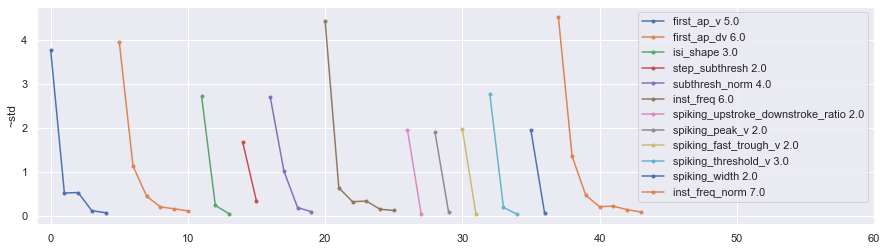

In [8]:
T,Tsc,T_labels,C,Csc,Csc_df = pc2timeseries(L=L)

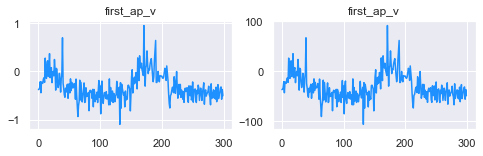

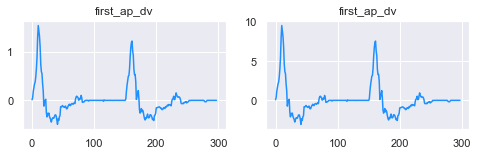

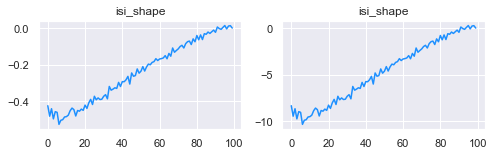

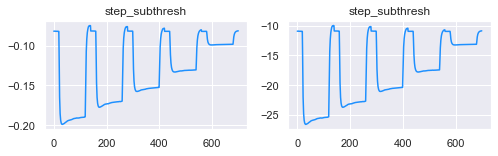

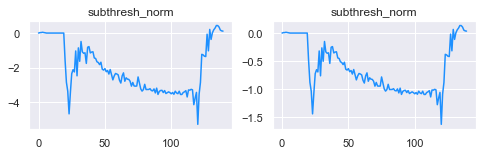

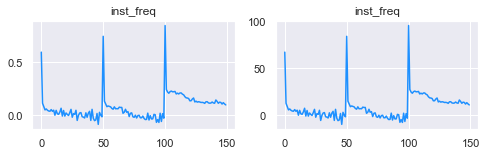

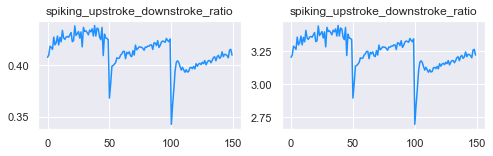

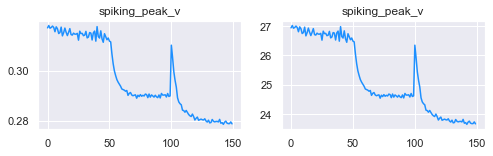

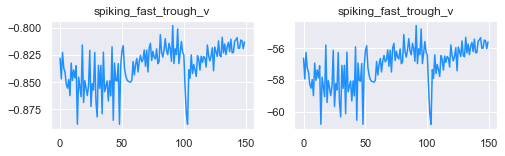

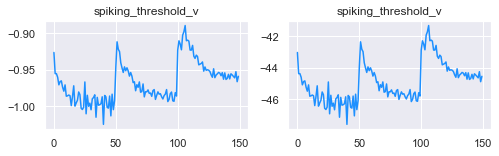

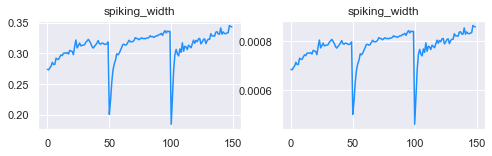

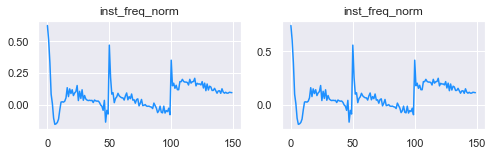

In [9]:
#Plot all sub experiment time series (reconstructed from the sPC representation) for particular cell:
cellid = 1000
for i in range(len(Tsc)):
    plt.figure(figsize=(8,2))
    plt.subplot(1,2,1)
    plt.plot(Tsc[i][cellid,:],color='dodgerblue')
    plt.title(T_labels[i])
    
    plt.subplot(1,2,2)
    plt.plot(T[i][cellid,:],color='dodgerblue')
    plt.title(T_labels[i])
    plt.show()

In [10]:
Csc_df.values.min()

-28.563517436573296

In [11]:
Csc_df.values.max()

18.48510099309704

<Figure size 1440x1440 with 0 Axes>

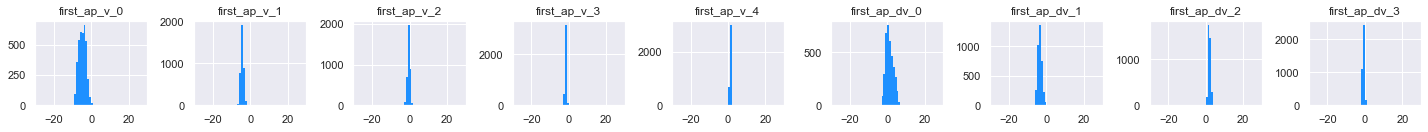

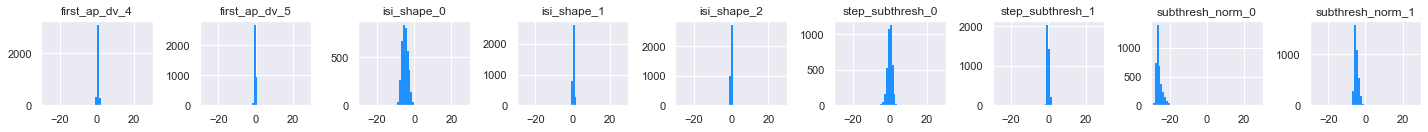

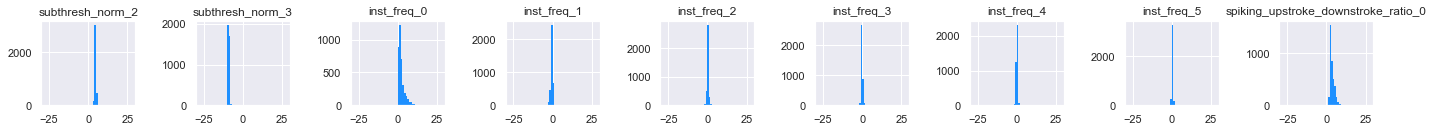

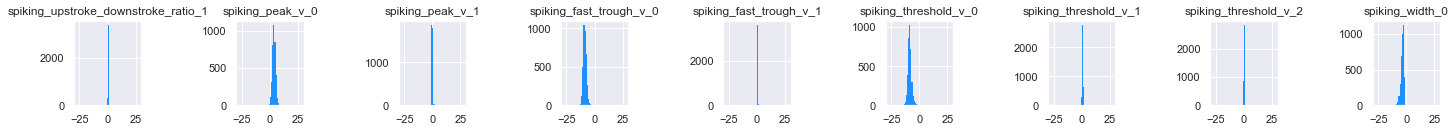

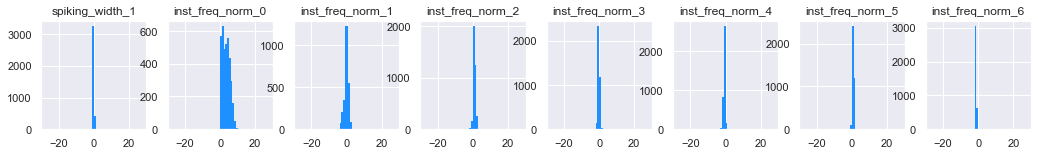

In [12]:
plt.figure(figsize = (20,20))
for i in range(Csc_df.shape[1]):
    if i%9==0:
        col = 1
        plt.figure(figsize = (20,2))
    plt.subplot(1,9,col)
    plt.hist(x=Csc_df.iloc[:,i].values,bins=np.arange(-30,31,1),edgecolor='None',color='dodgerblue')
    ax = plt.gca()
    ax.set_title(Csc_df.columns[i])
    ax.set_xlim(-30,30)
    if col==9:
        plt.tight_layout()
        plt.show()
    col=col+1

In [13]:
Csc_df.describe().transpose().round(2)

,count,mean,std,min,25%,50%,75%,max
first_ap_v_0,3708.0,-4.60,1.94,-10.33,-6.12,-4.55,-3.13,3.76
first_ap_v_1,3708.0,-4.43,0.72,-6.81,-4.93,-4.44,-3.96,-1.41
first_ap_v_2,3708.0,-0.45,0.73,-4.03,-0.90,-0.42,0.02,2.35
first_ap_v_3,3708.0,-1.66,0.34,-2.96,-1.83,-1.66,-1.47,0.11
first_ap_v_4,3708.0,1.22,0.26,0.13,1.05,1.21,1.38,2.66
first_ap_dv_0,3708.0,1.32,1.99,-3.72,-0.19,1.02,2.69,7.34
first_ap_dv_1,3708.0,-3.54,1.06,-6.92,-4.30,-3.61,-2.90,0.81
first_ap_dv_2,3708.0,2.03,0.67,-0.35,1.59,1.97,2.41,5.15
first_ap_dv_3,3708.0,-0.77,0.45,-2.42,-1.06,-0.76,-0.48,1.33
first_ap_dv_4,3708.0,0.49,0.40,-1.79,0.27,0.49,0.71,2.65


In [14]:
# S values and Csc values are expected to have the same order:
Csc_df.insert(loc=0,column='spec_id_label',value=S.spec_id_label.values)

In [15]:
# Order the scaled pc loadings by the matrices in the dataset
D_order = pd.DataFrame(data={'E_spec_id_label':D['E_spec_id_label']})
Csc_ordered = D_order.merge(right=Csc_df, how='left', left_on='E_spec_id_label', right_on='spec_id_label')
D['E_pc_scaled'] = Csc_ordered[D['spc_name']].values

In [16]:
#Renaming columns
D['E_pc_zscored'] = D['E_dat'].copy()
D['pc_name'] = D['spc_name'].copy()


In [17]:
#Ordering numeric cluster_id based on position along the hierarchical tree
from analysis_tree_helpers import HTree
htree_filename = '/Users/fruity/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/dend_RData_Tree_20181220.csv'
htree = HTree(htree_file=htree_filename)
htree = htree.get_subtree('n59') #Inhibitory tree
htree_df = htree.obj2df()
htree_df = htree_df[htree_df.isleaf].sort_values(by='x')
lut = list(zip(htree_df.child.values,np.arange(htree_df.child.values.size)))

D['cluster_id'] = np.zeros_like(D['clusterID'])

del D['clusterID']
del D['E_dat']
del D['spc_name']

In [18]:
D_updated = {}
for key in ['T_dat','T_spec_id_label','T_ispaired',
            'gene_id','cluster','cluster_id','cluster_color','sample_id','map_conf',
            'E_pc_zscored','E_pc_scaled','E_feature','E_spec_id_label','E_ispaired',
            'pc_name','feature_name','feature_mean','feature_std']:
    D_updated[key] = D[key].copy()

In [19]:
for key in D_updated.keys():
    if '__' not in key:
        print('{:20s}{}'.format(key,D_updated[key].shape))

T_dat               (3411, 1252)
T_spec_id_label     (3411,)
T_ispaired          (3411,)
gene_id             (1252,)
cluster             (3411,)
cluster_id          (3411,)
cluster_color       (3411,)
sample_id           (3411,)
map_conf            (3411,)
E_pc_zscored        (3411, 44)
E_pc_scaled         (3411, 44)
E_feature           (3411, 24)
E_spec_id_label     (3411,)
E_ispaired          (3411,)
pc_name             (44,)
feature_name        (24,)
feature_mean        (24,)
feature_std         (24,)


In [20]:
base_path = '/Users/fruity/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/'
sio.savemat(base_path+'PS_v5_beta_0-4_pc_scaled_ipxf_eqTE.mat',D_updated,do_compression=True)

In [21]:
#Tests
a = pd.DataFrame({'a1':['1','2','3','4'],'a2':['a','a','a','a']})
b = pd.DataFrame({'b1':['100','200','500','600'],'b2':['b','b','l','m']})
a.merge(b,how='left',left_on='a1',right_on='b1')

,a1,a2,b1,b2
0,1,a,NaN,NaN
1,2,a,NaN,NaN
2,3,a,NaN,NaN
3,4,a,NaN,NaN
